In [5]:
# System identification python code

####################### PACKAGES #######################
import numpy as np
import numpy.linalg
import numpy.matlib

from sklearn.preprocessing import PolynomialFeatures

from scipy.linalg import lstsq
from scipy.integrate import odeint

import pandas as pd

import matplotlib.pyplot as plt
from derivative import dxdt


In [27]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def duffing(x, t, gamma=0.1, kappa=1, epsilon=5):
    return [
            x[1],
            -gamma * x[1] - kappa * x[0] - epsilon * x[0] ** 3
            ]

gamma=0.1
kappa=1
epsilon=5


def lorenz63(x, t, sigma=10, rho=28, beta=8/3):
    return [
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - z[1],
        x[0] * x[1] - beta * x[2]
    ]

def finite_differences(t,x):
    
    #First order finite differences scheme
    
    x2 = x[1:]
    t2 = t[1:]
    
    x1 = x[0:-1]
    t1 = t[0:-1]
    
    dxdt = (x2 - x1)/(t2 - t1)
    t = t1
    
    return (t,dxdt)

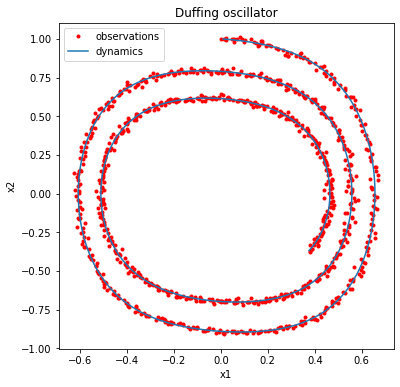

In [50]:
####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 10  # start and end
dt = 0.01  # time step
Nt = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n = 2 #Number of state variables
t_span = np.linspace(t0, tf, Nt)
x0 = [0, 1]
X = odeint(duffing, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]

#Compute true derivatives
dX = np.zeros((len(t_span),n))
dX[:,0] = x2
dX[:,1] =  -gamma * x2 - kappa * x1 - epsilon * x1 ** 3

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0.01
E = sigma * np.random.randn(Nt,2)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
t = t_span
m = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Duffing oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

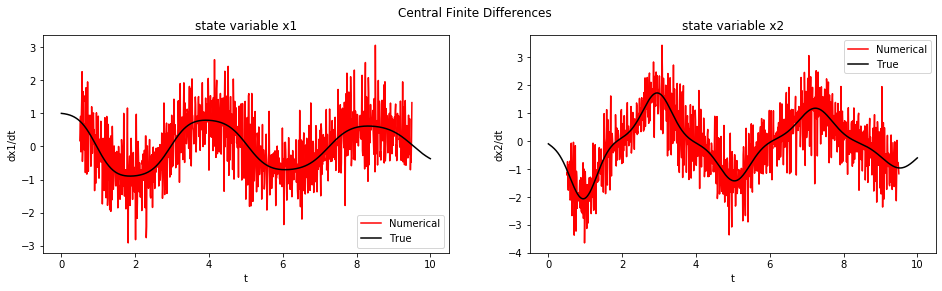

In [51]:
## NUMERICAL DIFFERENTIATION OF NOISY DATA (derivative Python library)

# 1. Finite differences with central differencing using 3 points.
# result1 = dxdt(x, t, kind="finite_difference", k=1)
dy1dt_FD = dxdt(y1, t, kind="finite_difference", k=1)
dy2dt_FD = dxdt(y2, t, kind="finite_difference", k=1)


#Trim the ends
trim  = int(0.1 * m/2)#% of samples to trim 

dy1dt_FD = dy1dt_FD[trim:m-trim]
dy2dt_FD = dy2dt_FD[trim:m-trim]
tt = t[trim:m-trim]

#Compare true and numerical derivatives
fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(16,4))
fig.suptitle('Central Finite Differences')
ax1.plot(tt,dy1dt_FD,'r')
ax1.plot(t,dX[:,0],'k')
ax1.set_title('state variable x1')
ax1.set_xlabel('t')
ax1.set_ylabel('dx1/dt')
ax1.legend(['Numerical','True'])

ax2.plot(tt,dy2dt_FD,'r')
ax2.plot(t,dX[:,1],'k')
ax2.set_title('state variable x2')
ax2.set_xlabel('t')
ax2.set_ylabel('dx2/dt')
ax2.legend(['Numerical','True'])
plt.show()

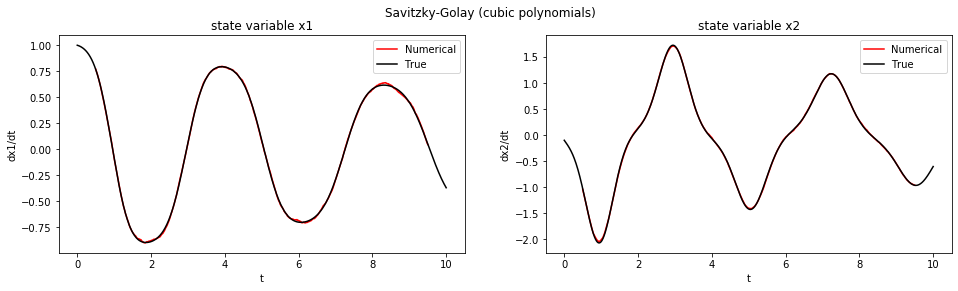

In [52]:
# 2. Savitzky-Golay using cubic polynomials to fit in a centered window of length 1
# result2 = dxdt(x, t, kind="savitzky_golay", left=.5, right=.5, order=3)
dy1dt_SG = dxdt(y1, t, kind="savitzky_golay", left=.5, right=.5, order=3)
dy2dt_SG = dxdt(y2, t, kind="savitzky_golay", left=.5, right=.5, order=3)

#Trim the ends
trim  = int(0.1 * m/2)#% of samples to trim 

dy1dt_SG = dy1dt_SG[trim:m-trim]
dy2dt_SG = dy2dt_SG[trim:m-trim]
tt = t[trim:m-trim]

#Compare true and numerical derivatives
fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(16,4))
fig.suptitle('Savitzky-Golay (cubic polynomials)')

ax1.plot(tt,dy1dt_SG,'r')
ax1.plot(t,dX[:,0],'k')
ax1.set_title('state variable x1')
ax1.set_xlabel('t')
ax1.set_ylabel('dx1/dt')
ax1.legend(['Numerical','True'])

ax2.plot(tt,dy2dt_SG,'r')
ax2.plot(t,dX[:,1],'k')
ax2.set_title('state variable x2')
ax2.set_xlabel('t')
ax2.set_ylabel('dx2/dt')
ax2.legend(['Numerical','True'])
plt.show()

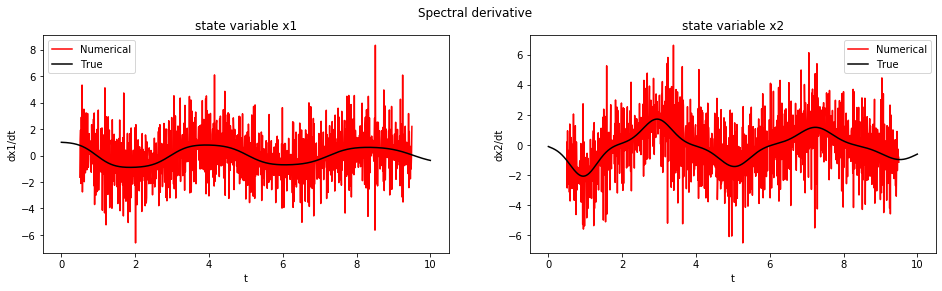

In [53]:
# 3. Spectral derivative
# result3 = dxdt(x, t, kind="spectral")
dy1dt_SD = dxdt(y1, t, kind="spectral")
dy2dt_SD = dxdt(y2, t, kind="spectral")

#Trim the ends
trim  = int(0.1 * m/2)#% of samples to trim 

dy1dt_SD = dy1dt_SD[trim:m-trim]
dy2dt_SD = dy2dt_SD[trim:m-trim]
tt = t[trim:m-trim]

#Compare true and numerical derivatives
fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(16,4))
fig.suptitle('Spectral derivative')

ax1.plot(tt,dy1dt_SD,'r')
ax1.plot(t,dX[:,0],'k')
ax1.set_title('state variable x1')
ax1.set_xlabel('t')
ax1.set_ylabel('dx1/dt')
ax1.legend(['Numerical','True'])

ax2.plot(tt,dy2dt_SD,'r')
ax2.plot(t,dX[:,1],'k')
ax2.set_title('state variable x2')
ax2.set_xlabel('t')
ax2.set_ylabel('dx2/dt')
ax2.legend(['Numerical','True'])
plt.show()

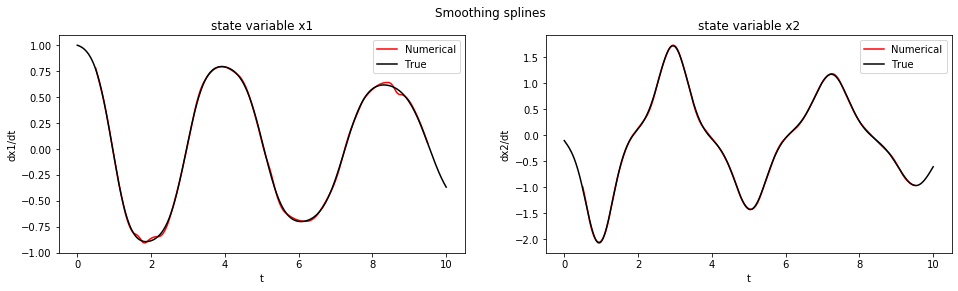

In [54]:
# 4. Spline derivative with smoothing set to 0.01
#result4 = dxdt(x, t, kind="spline", s=1e-2)
dy1dt_SS = dxdt(y1, t, kind="spline", s=0.1)
dy2dt_SS = dxdt(y2, t, kind="spline", s=0.1)

#Trim the ends
trim  = int(0.1 * m/2)#% of samples to trim 

dy1dt_SS = dy1dt_SS[trim:m-trim]
dy2dt_SS = dy2dt_SS[trim:m-trim]
tt = t[trim:m-trim]

#Compare true and numerical derivatives
fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(16,4))
fig.suptitle('Smoothing splines')

ax1.plot(tt,dy1dt_SS,'r')
ax1.plot(t,dX[:,0],'k')
ax1.set_title('state variable x1')
ax1.set_xlabel('t')
ax1.set_ylabel('dx1/dt')
ax1.legend(['Numerical','True'])

ax2.plot(tt,dy2dt_SS,'r')
ax2.plot(t,dX[:,1],'k')
ax2.set_title('state variable x2')
ax2.set_xlabel('t')
ax2.set_ylabel('dx2/dt')
ax2.legend(['Numerical','True'])
plt.show()

/home/alexandre/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.508794513185437, tolerance: 0.015546268353637175
  positive)
/home/alexandre/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.181613222129394, tolerance: 0.06029238925159615
  positive)


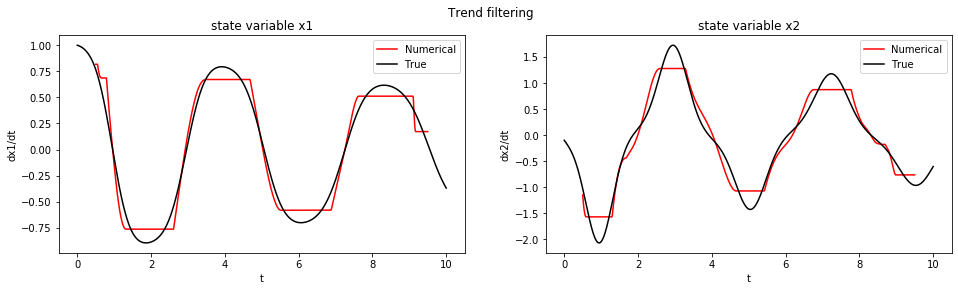

In [55]:
# 5. Total variational derivative with regularization set to 0.01
# result5 = dxdt(x, t, kind="trend_filtered", order=0, alpha=1e-2)
dy1dt_TF = dxdt(y1, t, kind="trend_filtered", order=0, alpha=0.01)
dy2dt_TF = dxdt(y2, t, kind="trend_filtered", order=0, alpha=0.01)

#Trim the ends
trim  = int(0.1 * m/2)#% of samples to trim 

dy1dt_TF = dy1dt_TF[trim:m-trim]
dy2dt_TF = dy2dt_TF[trim:m-trim]
tt = t[trim:m-trim]

#Compare true and numerical derivatives
fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(16,4))
fig.suptitle('Trend filtering')

ax1.plot(tt,dy1dt_TF,'r')
ax1.plot(t,dX[:,0],'k')
ax1.set_title('state variable x1')
ax1.set_xlabel('t')
ax1.set_ylabel('dx1/dt')
ax1.legend(['Numerical','True'])

ax2.plot(tt,dy2dt_TF,'r')
ax2.plot(t,dX[:,1],'k')
ax2.set_title('state variable x2')
ax2.set_xlabel('t')
ax2.set_ylabel('dx2/dt')
ax2.legend(['Numerical','True'])
plt.show()